# Uploading and Retrieving Single Image Profiles to WhyLabs

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/whylabs/whylogs/blob/dev/felipe/single-image-example/python/examples/integrations/writers/Single_Image_Profile_to_WhyLabs.ipynb)

In this example, we'll walk through the process of uploading single image profiles to WhyLabs.

Additionally, we'll explain how to retrieve the previously uploaded original profiles.

> Note: This example assumes that you have an organization configured for single profile uploads. If you don't have one, please contact the WhyLabs team.

## Installing whylogs

In [ ]:
%pip install whylogs[all] -q

## WhyLabs Credentials

Let's set the WhyLabs credentials as environment variables. The WhyLabs Writer will check for the existence of these variables in order to send the profiles to your dashboard.

In [13]:
import getpass
import os

# set your datased_id (or model_id) here - should be something like "model-xxxx"
print("Enter your WhyLabs Dataset ID")
os.environ["WHYLABS_DEFAULT_DATASET_ID"] = input()


# set your API key here
print("Enter your WhyLabs API key")
os.environ["WHYLABS_API_KEY"] = getpass.getpass()
print("Using API Key ID: ", os.environ["WHYLABS_API_KEY"][0:10])

Enter your WhyLabs Dataset ID
model-3
Enter your WhyLabs API key
··········
Using API Key ID:  PUpqwDhQck


## Defining the images

For this example, we will create two images with the PIL library. We will log each image in single profiles in order to upload them to WhyLabs.

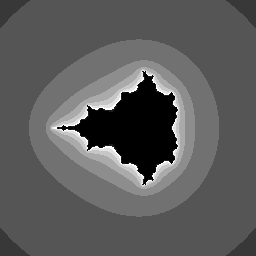

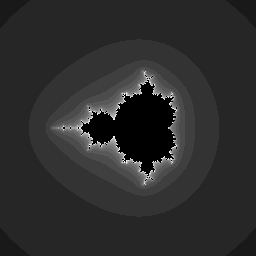

In [3]:
from PIL import Image

img1 = Image.effect_mandelbrot((256, 256), (-3, -2.5, 2, 2.5), 9)
img2 = Image.effect_mandelbrot((256, 256), (-3, -2.5, 2, 2.5), 20)

display(img1)
display(img2)

We will use the concept of trace id's to be able to trace our single image profiles. Let's generate uuids for both images and use the identifiers as our trace IDs.



In [4]:
import uuid

# Here we show that you can pass in your own string for a unique identifier as a trace_id
trace_id1 = str(uuid.uuid4())
trace_id2 = str(uuid.uuid4())
print(f"trace ids generated: {trace_id1}, and {trace_id2}")

trace ids generated: 79e0aee2-fac1-4fb0-8912-f54cf0ec0995, and 03e3dcbc-bdcf-4729-b2bc-09d7dc63352e


We can now call `log_image` to create profiles for each image. We will set the profile's trace ID by passing the uuids into each profile's metadada:

In [5]:
from whylogs.extras.image_metric import log_image

profile1 = log_image(img1).profile()
profile2 = log_image(img2).profile()

profile1._metadata = {"whylabs.traceId": trace_id1}
profile2._metadata = {"whylabs.traceId": trace_id2}

print(profile1.view()._metadata)
print(profile2.view()._metadata)

{'whylabs.traceId': '79e0aee2-fac1-4fb0-8912-f54cf0ec0995'}
{'whylabs.traceId': '03e3dcbc-bdcf-4729-b2bc-09d7dc63352e'}


## Uploading to WhyLabs

We will create a WhyLabsWriter to upload our profiles to our WhyLabs dashboard:

In [6]:
from whylogs.api.writer.whylabs import WhyLabsWriter
whylabs_writer = WhyLabsWriter()

whylabs_writer.write(file=profile1.view())
whylabs_writer.write(file=profile2.view())

(True, 'log-S1PdDsygMQV24g7f')

## Retrieving the Profiles

To retrieve the profiles, we need to provide the proper Trace ID and make use of the whylabs client for the `get_profile_traces` API. Let's wrap the necessary steps into a single function to retrieve the profiles based on the WhyLabs writer and trace id:

In [9]:
from whylabs_client.api.dataset_profile_api import DatasetProfileApi
from whylabs_client.model.profile_traces_response import ProfileTracesResponse
from whylogs.core import DatasetProfileView
import time

def get_profile_from_whylabs(writer, trace_id:str):
  dataset_api = DatasetProfileApi(writer._api_client)
  download_url = None
  for _ in range(15):
    response: ProfileTracesResponse = dataset_api.get_profile_traces(
                    org_id=writer._org_id,
                    dataset_id=writer._dataset_id,
                    trace_id=trace_id,
                )
    traces = response.get("traces")
    if len(traces) == 0:
      time.sleep(2)
    else:
      download_url = traces[0]["download_url"]
      break
  if download_url is None:
    raise Exception(f"No results found for trace id {trace_id}")
  headers = {"Content-Type": "application/octet-stream"}
  downloaded_profile = writer._s3_pool.request("GET", download_url, headers=headers, timeout=writer._timeout_seconds)
  deserialized_view = DatasetProfileView.deserialize(downloaded_profile.data)
  return deserialized_view

downloaded_view_1 = get_profile_from_whylabs(whylabs_writer, trace_id1)
downloaded_view_2 = get_profile_from_whylabs(whylabs_writer, trace_id2)

print(f"Downloaded profiles with trace id {downloaded_view_1._metadata}, {downloaded_view_2._metadata}")

Downloaded profiles with trace id {'whylabs.traceId': '79e0aee2-fac1-4fb0-8912-f54cf0ec0995'}, {'whylabs.traceId': '03e3dcbc-bdcf-4729-b2bc-09d7dc63352e'}


## Comparing the Profiles

Let's make sure that the retrieved profiles are indeed equal to the uploaded ones. To do so, let's visualize each profile for the first image with the __Notebook Profile Visualizer__. This will give us a profile visualization with the calculated metrics for the image.

Here's the report for the original profile:

In [10]:
from whylogs.viz import NotebookProfileVisualizer

visualization = NotebookProfileVisualizer()
visualization.set_profiles(target_profile_view=profile1.view())

visualization.profile_summary()

And this is the report for the retrieved profile. We should see the same features and values in both profiles.

In [11]:
visualization.set_profiles(target_profile_view=downloaded_view_1)

visualization.profile_summary()